In [1]:
import requests
import random
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
import sqlite3
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import datetime
# !pip install --upgrade geopandas
import geopandas as gpd


#Data retrieval

In [2]:
# API URL for weather data
api_url = "https://archive-api.open-meteo.com/v1/archive?latitude=36.82&longitude=10.17&start_date=2018-06-16&end_date=2023-06-16&daily=weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,sunrise,sunset,shortwave_radiation_sum,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,windspeed_10m_max,et0_fao_evapotranspiration&timezone=auto&min=&max="

# Make the API request
response = requests.get(api_url)

# Extract the JSON response
data = response.json()

# Extract the daily weather data from the API response
daily_data = data['daily']

# Create an empty DataFrame
df = pd.DataFrame(daily_data)
df = df.drop(['snowfall_sum'], axis=1)
# Convert date/time columns to datetime format
date_columns = ['time', 'sunrise', 'sunset']
df[date_columns] = df[date_columns].apply(pd.to_datetime)

# Handle missing values
df = df.fillna(method='ffill')

# Convert numeric columns to appropriate data types
numeric_columns = ['weathercode', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'shortwave_radiation_sum',
                   'precipitation_sum', 'rain_sum', 'precipitation_hours', 'windspeed_10m_max',
                   'et0_fao_evapotranspiration']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)

# Print the preprocessed DataFrame
print(df.head())


        time  weathercode  temperature_2m_max  temperature_2m_min  \
0 2018-06-16          1.0                27.1                18.7   
1 2018-06-17          2.0                27.3                18.5   
2 2018-06-18          0.0                27.1                18.8   
3 2018-06-19          1.0                26.5                18.3   
4 2018-06-20         51.0                27.8                18.9   

   temperature_2m_mean             sunrise              sunset  \
0                 22.5 2018-06-16 04:58:00 2018-06-16 19:41:00   
1                 22.6 2018-06-17 04:58:00 2018-06-17 19:42:00   
2                 22.5 2018-06-18 04:58:00 2018-06-18 19:42:00   
3                 22.5 2018-06-19 04:58:00 2018-06-19 19:42:00   
4                 23.2 2018-06-20 04:58:00 2018-06-20 19:42:00   

   shortwave_radiation_sum  precipitation_sum  rain_sum  precipitation_hours  \
0                    26.21                0.0       0.0                  0.0   
1                    25.61  

#Correlation matrix

C:\Users\MARAM\AppData\Local\Temp\ipykernel_19264\3013671047.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


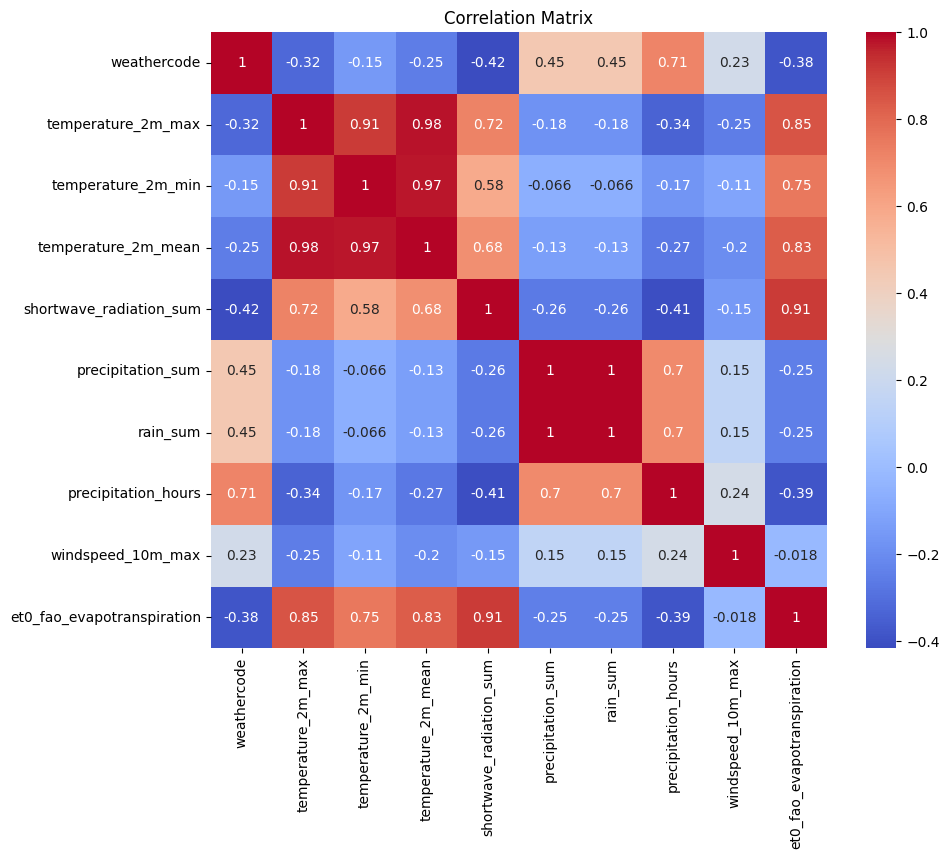

In [3]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


-weathercode has a negative correlation with several variables such as temperature_2m_max, apparent_temperature_max, apparent_temperature_mean, and shortwave_radiation_sum. This suggests that as the weathercode increases, these variables tend to decrease.

-temperature_2m_max, temperature_2m_min, temperature_2m_mean, apparent_temperature_max, apparent_temperature_min, and apparent_temperature_mean have strong positive correlations among themselves. This indicates that these temperature-related variables are highly correlated and tend to move in the same direction.

-precipitation_sum, rain_sum, and precipitation_hours have positive correlations with weathercode, indicating that as the weather conditions change, these precipitation-related variables tend to increase.

-shortwave_radiation_sum shows a moderate positive correlation with et0_fao_evapotranspiration, suggesting that higher shortwave radiation is associated with higher evapotranspiration.

-windspeed_10m_max and windgusts_10m_max have strong positive correlations, indicating that they are closely related and tend to move together.


#Plotting temperature_2m_mean and shortwave_radiation_sum

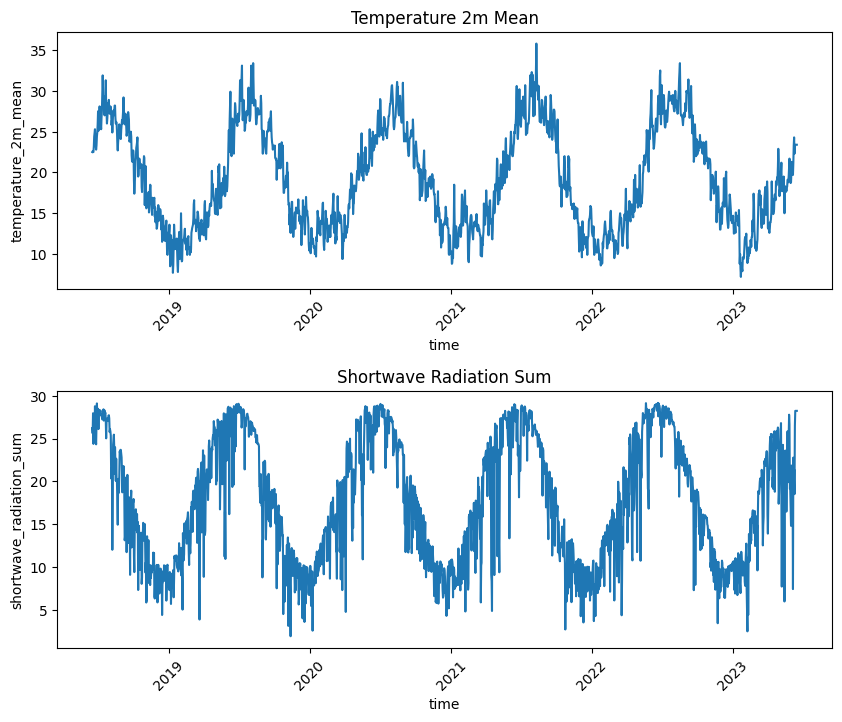

In [7]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot temperature_2m_mean
sns.lineplot(data=df, x='time', y='temperature_2m_mean', ax=axes[0])
axes[0].set_title('Temperature 2m Mean')

# Plot shortwave_radiation_sum
sns.lineplot(data=df, x='time', y='shortwave_radiation_sum', ax=axes[1])
axes[1].set_title('Shortwave Radiation Sum')

# Rotate x-axis labels for better visibility
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()


In [4]:
# Calculate summary statistics
summary_stats = df.describe()
print(summary_stats)

       weathercode  temperature_2m_max  temperature_2m_min  \
count  1827.000000         1827.000000         1827.000000   
mean     19.059661           23.596716           15.428298   
std      25.001035            7.033932            5.584993   
min       0.000000            9.400000            3.400000   
25%       1.000000           17.700000           10.700000   
50%       2.000000           22.500000           14.800000   
75%      51.000000           29.400000           20.600000   
max      65.000000           44.700000           28.500000   

       temperature_2m_mean  shortwave_radiation_sum  precipitation_sum  \
count          1827.000000              1827.000000        1827.000000   
mean             19.157581                17.530739           1.116749   
std               6.135806                 7.225907           4.043932   
min               7.200000                 1.900000           0.000000   
25%              13.900000                10.815000           0.000000 

#Train/Test split

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into X and y
# X = df[['time']]
df['time'] = pd.to_datetime(df['time'])

# Extract relevant features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

X = df[['year','month','day']]
# Drop the original 'time' column
df = df.drop('time', axis=1)
Y = df[['temperature_2m_mean', 'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum', 'windspeed_10m_max', 'et0_fao_evapotranspiration']]

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


#Train and eval

## Model training and eval

---



In [12]:
# Initialize the XGBoost model
model = xgb.XGBRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
# Save model
model.save_model('xgboost_model.model')


Mean Squared Error: 16.983997869020232


#Make prediction

In [49]:
def predict_weather(input_date, model_path):
    # Load the XGBoost model
    model = xgb.Booster()
    model.load_model(model_path)

    try:
        # Convert the user date to a dataframe
        input_date = pd.to_datetime(input_date)
        input_date = pd.DataFrame({
            'year': [input_date.year],
            'month': [input_date.month],
            'day': [input_date.day]
        })

        # Convert the data to DMatrix format
        user_data_dmatrix = xgb.DMatrix(input_date)

        # Make a prediction for the provided date
        prediction = model.predict(user_data_dmatrix)

        # Define labels for the predicted values
        labels = ['temperature_2m_mean', 'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum', 'windspeed_10m_max', 'et0_fao_evapotranspiration']

        # Adjust negative values for rain_sum and precipitation_sum to 0
        for i, label in enumerate(labels):
            if label in ['rain_sum', 'precipitation_sum'] and prediction[0][i] < 0:
                prediction[0][i] = 0

        # Print out the predicted values alongside their corresponding labels
        for label, value in zip(labels, prediction[0]):
            print(f"The predicted {label} is: {value:.2f}")

    except ValueError:
        print("You entered an invalid date. Please enter the date in the format YYYY-MM-DD.")

# # Example usage
# # user_date_input = input("Please enter a date in the format YYYY-MM-DD: ")
# user_date_input = " 2023-06-19"
# model_name_input = 'xgboost_model.model'
# predict_weather(user_date_input, model_name_input)

#Store the weather data in an SQLite database for future use

In [8]:

# Create a connection to the database
db_connection = sqlite3.connect("weather_data.db")
cursor = db_connection.cursor()

# Function to create the weather table
def create_weather_table():
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS weather (
            location TEXT,
            date TEXT,
            weathercode INTEGER,
            temperature_max REAL,
            temperature_min REAL,
            temperature_mean REAL,
            apparent_temperature_max REAL,
            apparent_temperature_min REAL,
            apparent_temperature_mean REAL,
            sunrise TEXT,
            sunset TEXT,
            shortwave_radiation_sum REAL,
            precipitation_sum REAL,
            rain_sum REAL,
            snowfall_sum REAL,
            precipitation_hours REAL,
            windspeed_max REAL,
            windgusts_max REAL,
            winddirection_dominant REAL,
            et0_fao_evapotranspiration REAL
        )
    """)

# Function to get weather data for a specific location
def get_weather_data(location):
    cursor.execute("SELECT * FROM weather WHERE location=?", (location,))
    weather_data = cursor.fetchone()
    return weather_data

# Iterate over the data and insert it into the database
for daily_data in data['daily']:
    if isinstance(daily_data, str):
        # If daily_data is a string, use it as the date directly
        date = daily_data
        weather_data_list = data['daily'][daily_data]
    else:
        # If daily_data is a dictionary, extract the date and get the weather data list
        date = daily_data['time']
        weather_data_list = daily_data['data']

    if isinstance(weather_data_list, list):
        # Handle the case where weather_data_list is a list
        for weather_data in weather_data_list:
            if isinstance(weather_data, dict):
                location = location_name
                weathercode = weather_data.get('weathercode')
                temperature_max = weather_data.get('temperature_2m_max')
                temperature_min = weather_data.get('temperature_2m_min')
                temperature_mean = weather_data.get('temperature_2m_mean')
                apparent_temperature_max = weather_data.get('apparent_temperature_max')
                apparent_temperature_min = weather_data.get('apparent_temperature_min')
                apparent_temperature_mean = weather_data.get('apparent_temperature_mean')
                sunrise = weather_data.get('sunrise')
                sunset = weather_data.get('sunset')
                shortwave_radiation_sum = weather_data.get('shortwave_radiation_sum')
                precipitation_sum = weather_data.get('precipitation_sum')
                rain_sum = weather_data.get('rain_sum')
                snowfall_sum = weather_data.get('snowfall_sum')
                precipitation_hours = weather_data.get('precipitation_hours')
                windspeed_max = weather_data.get('windspeed_10m_max')
                windgusts_max = weather_data.get('windgusts_10m_max')
                winddirection_dominant = weather_data.get('winddirection_10m_dominant')
                et0_fao_evapotranspiration = weather_data.get('et0_fao_evapotranspiration')

                # Insert the values into the database table
                cursor.execute("""
                    INSERT INTO weather (
                        location, date, weathercode, temperature_max, temperature_min, temperature_mean,
                        apparent_temperature_max, apparent_temperature_min, apparent_temperature_mean,
                        sunrise, sunset, shortwave_radiation_sum, precipitation_sum, rain_sum, snowfall_sum,
                        precipitation_hours, windspeed_max, windgusts_max, winddirection_dominant,
                        et0_fao_evapotranspiration
                    )
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                """, (location, date, weathercode, temperature_max, temperature_min, temperature_mean,
                      apparent_temperature_max, apparent_temperature_min, apparent_temperature_mean,
                      sunrise, sunset, shortwave_radiation_sum, precipitation_sum, rain_sum, snowfall_sum,
                      precipitation_hours, windspeed_max, windgusts_max, winddirection_dominant,
                      et0_fao_evapotranspiration))

    else:
        # Handle the case where weather_data_list is a dictionary
        location = location_name
        weathercode = weather_data_list.get('weathercode')
        temperature_max = weather_data_list.get('temperature_2m_max')
        temperature_min = weather_data_list.get('temperature_2m_min')
        temperature_mean = weather_data_list.get('temperature_2m_mean')
        apparent_temperature_max = weather_data_list.get('apparent_temperature_max')
        apparent_temperature_min = weather_data_list.get('apparent_temperature_min')
        apparent_temperature_mean = weather_data_list.get('apparent_temperature_mean')
        sunrise = weather_data_list.get('sunrise')
        sunset = weather_data_list.get('sunset')
        shortwave_radiation_sum = weather_data_list.get('shortwave_radiation_sum')
        precipitation_sum = weather_data_list.get('precipitation_sum')
        rain_sum = weather_data_list.get('rain_sum')
        snowfall_sum = weather_data_list.get('snowfall_sum')
        precipitation_hours = weather_data_list.get('precipitation_hours')
        windspeed_max = weather_data_list.get('windspeed_10m_max')
        windgusts_max = weather_data_list.get('windgusts_10m_max')
        winddirection_dominant = weather_data_list.get('winddirection_10m_dominant')
        et0_fao_evapotranspiration = weather_data_list.get('et0_fao_evapotranspiration')

        # Insert the values into the database table
        cursor.execute("""
            INSERT INTO weather (
                location, date, weathercode, temperature_max, temperature_min, temperature_mean,
                apparent_temperature_max, apparent_temperature_min, apparent_temperature_mean,
                sunrise, sunset, shortwave_radiation_sum, precipitation_sum, rain_sum, snowfall_sum,
                precipitation_hours, windspeed_max, windgusts_max, winddirection_dominant,
                et0_fao_evapotranspiration
            )
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (location, date, weathercode, temperature_max, temperature_min, temperature_mean,
              apparent_temperature_max, apparent_temperature_min, apparent_temperature_mean,
              sunrise, sunset, shortwave_radiation_sum, precipitation_sum, rain_sum, snowfall_sum,
              precipitation_hours, windspeed_max, windgusts_max, winddirection_dominant,
              et0_fao_evapotranspiration))

# Commit the changes to the database
db_connection.commit()


#Chatbot

In [52]:
# Function to generate a random response
def generate_response():
    responses = [
        "I'm sorry, I didn't understand that. Would you like a prediction?",
        "Could you please rephrase your statement?",
        "I'm afraid I don't have the information you're looking for. Would you like a prediction?",
        "Sorry, I can't assist with that particular request. Would you like a prediction?"
    ]
    return random.choice(responses)

# Function to handle user input and provide responses
def chatbot(model_path):
    print("Hey there! I'm your weather buddy. Ask and I'll sprinkle some forecasts your way!")

    while True:
        user_input = input("predict or exit: ").lower().strip()

        # Check if the user wants to predict values
        if user_input == "predict":
            user_date_input = input("Please enter a date in the format YYYY-MM-DD: ")
            predict_weather(user_date_input, model_path)

        # Check if the user wants to exit
        elif user_input == "exit":
            break

        # Generate a random response for other inputs
        else:
            print(generate_response())

    print("Thank you for using the Chatbot!")

# Call the chatbot function
chatbot('xgboost_model.model')


Hey there! I'm your weather buddy. Ask and I'll sprinkle some forecasts your way!
I'm afraid I don't have the information you're looking for. Would you like a prediction?
Thank you for using the Chatbot!
